# Example — Building ion current models from data 


This example applies some conventional approaches to using voltage-clamp data to parameterize ion channel models. A first step is for us to construct the steady-state activation curve for the fast cardiac sodium current from an existing data set.

Let's import and inspect the data.

In [2]:
import neo
import pylab as plt
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline

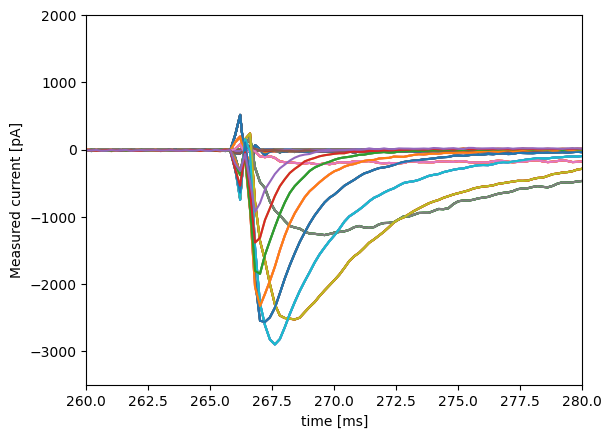

In [3]:
sweep_num = 15 # the number of voltage steps
V_steps = np.linspace(-120, 20, 15) # the voltage step values
SR = 5 #(kHz)
sweep_length = 5000 #(points)
sweep_duration = sweep_length/SR #(ms)
time = np.linspace(0.2, sweep_duration, sweep_length) # construct the time vector
I = np.zeros(shape=(sweep_length,sweep_num)) # initialize the data array

f = neo.io.AxonIO('Active.abf')
bl = f.read_block()
for idx, seg in enumerate(bl.segments):
    data = np.array(seg.analogsignals[0])
    I[:,idx] = data[:,0]
    plt.plot(time, I) 
    plt.xlabel('time [ms]') 
    plt.ylabel('Measured current [pA]'); 
    plt.xlim([260, 280])
    plt.ylim([-3500, 2000])
plt.show()



And with some simple peak-finding we can have the maximum inward $I_{Na}$ at each voltage to construct our steady-state activation curve:



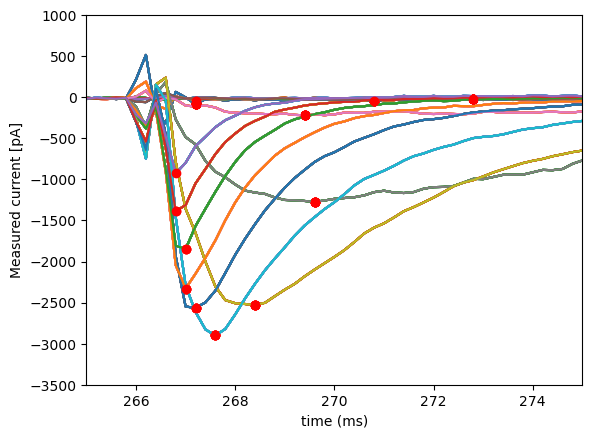

In [4]:
peak = np.zeros(15) #initialize arrays to store the times, indices, and values of the peak for each voltage step
peak_index = np.zeros(15)
t_peak = np.zeros(15)

# loop to find peaks and store them
for i in range(sweep_num):
    # define a search range for finding the peak inward current
    start = int(5000*(266.6/1000))
    finish = int(1500)
    search = I[start:finish,i] 
    # find the peak value, its index, and the time at the peak
    peak[i] = search.min()
    peak_index[i] = search.argmin()+start
    t_peak[i] = time[int(peak_index[i])]
    # plot a close-up of the time-series for each voltage step and the peak you have picked out 
    plt.plot(time, I,t_peak,peak,'ro'); plt.xlabel('time [ms]'); plt.ylabel('Measured current [pA]');
    plt.xlim([265, 275]); plt.ylim([-3500, 1000])
    plt.xlabel('time (ms)')
plt.show()

## Extracting the steady-state activation curve

Now we have the peak values for the current at each step potential. We can reduce this to arrive at the steady state activation relationship. This in turn allows us to parameterize a channel model for  voltage-dependence of activation.

#### 1. The steady-state I-V relationship

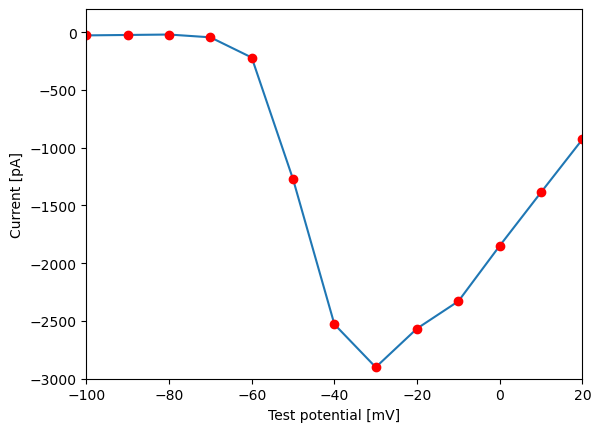

In [17]:
plt.figure()

V_steps = np.linspace(-120, 20, 15)
plt.plot(V_steps, peak,V_steps, peak,'ro'); plt.xlabel('Test potential [mV]'); plt.ylabel('Current [pA]')
plt.xlim([-100, 20])
plt.ylim([-3000, 200])
plt.show()

#### 2. The steady-state activation curve (g-V relationship)
We can now plot the steady-state activation curve assuming an extracellular $Na^+$ concentration of 130 mM and an intracellular concentration of 10 mM.

(-100.0, 20.0)

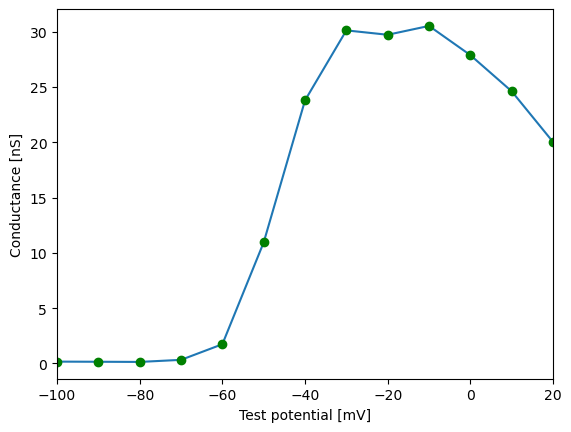

In [18]:
plt.figure()

R = 8.314
T = 300 
z = 1
F = 96485
Co = 130
Ci = 10

E_Na = (R*T/(z*F))*math.log(Co/Ci) # Nernst 
E_Na = E_Na*1000 # mV

# Your code here:

EC_grad = V_steps-E_Na # Electrochemical force (mV)
g_Na = peak/(EC_grad) # conductance (nS)
norm_g_Na = g_Na/g_Na.max() # normalized conductance

plt.plot(V_steps,g_Na,V_steps, g_Na,'go'); plt.xlabel('Test potential [mV]'); plt.ylabel('Conductance [nS]')
plt.xlim([-100, 20])

Note that this curve decays at more positive potentials. This is not physiological and indicates some contamination of the peak current relationship.

#### 3. Using the original current traces, we can also fit exponential decay relationships:
### $I(t) = A \cdot e^{-t/\tau} + C$ 
#### to extract the decay time-constant ($\tau$), a key parameter for paramterizing inactivation rate and its voltage-dependence

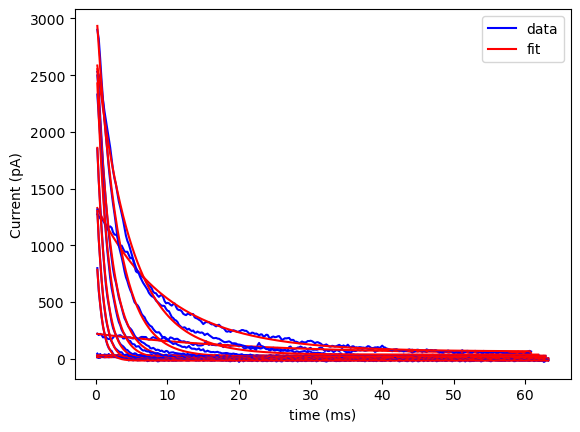

Text(0, 0.5, '$\\tau$ (ms)')

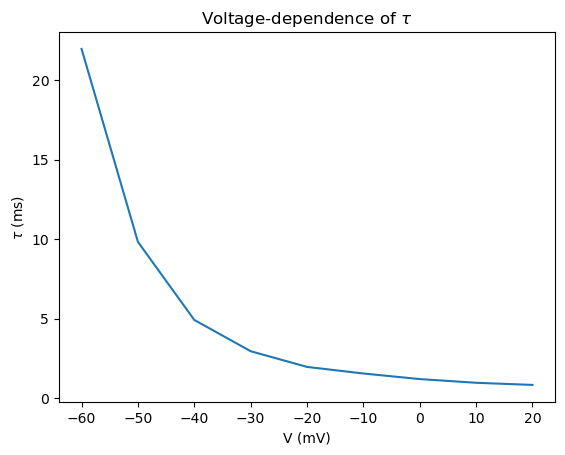

In [24]:
from scipy.optimize import curve_fit

tau = np.zeros(15)
# define the decay function to this data range
def exp_decay(t,A,K,C): 
    return np.array(A * np.exp(-t / K) + C)
def exp_fit(t,y): 
    params, cov = curve_fit(exp_decay, t, y)
    A, K, C = params
    return A, K, C

# fitting tau:
tau = np.zeros(len(V_steps))
plt.figure()
# loop to find decay constants and store them
for idx, seg in enumerate(bl.segments):
    I = np.array(seg.analogsignals[0])
    I = I[:,0]
    
    # define the range for inactivation fitting
    start = int(5000*(t_peak[idx]/1000))
    finish = int(5000*(330/1000))
    short_I = 0-I[start:finish]
    short_t = time[start:finish]-time[start-1]
    
    # fit the exponential decay function
    A, K, C = exp_fit(short_t,short_I)
    
    # plot the data
    plt.plot(short_t, short_I,'b')
    
    # plot the fits
    fit_I = exp_decay(short_t,A,K,C)
    plt.plot(short_t, fit_I,'r')
    
    # store the time constants
    tau[idx] = K
plt.xlabel('time (ms)')
plt.ylabel('Current (pA)')
plt.legend({'data','fit'})
plt.show()
plt.figure()
plt.plot(V_steps[6:], tau[6:])
plt.title(r'Voltage-dependence of $\tau$')
plt.xlabel('V (mV)')
plt.ylabel(r'$\tau$ (ms)')

